In [1]:
# https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv

In [17]:
import pandas as pd

In [18]:
'''
Chapter 6: Building a Recommendation Engine 
    Overview of Siamese BERT Architectures 
    Fine-Tuning Siamese BERT for Recommendations 
'''

'\nChapter 6: Building a Recommendation Engine \n    Overview of Siamese BERT Architectures \n    Fine-Tuning BERT for Classifying + Tagging Items\n    Fine-Tuning Siamese BERT for Recommendations \n'

In [30]:
pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv').dropna()
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [21]:
import re
import string

def clean_text(text):
    # Remove non-printable characters
    text = ''.join(filter(lambda x: x in string.printable, text))
    
    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s{2,}', ' ', text).strip()

    return text.strip()


def get_anime_description(anime_row):
    """
    Generates a custom description for an anime title based on various features from the input data.

    :param anime_row: A row from the MyAnimeList dataset containing relevant anime information.
    :return: A formatted string containing a custom description of the anime.
    """

    # Determine the type of anime (TV show or other)
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # Create a formatted description using the relevant features from the input data
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}.\n"
        f"Its genres are {anime_row['Genres']}\n"
    )

    return clean_text(description)


In [22]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [42]:
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)


In [29]:
watching_status = pd.read_csv('../data/anime/watching_status.csv').dropna()
print(watching_status.shape)
watching_status

(5, 2)


,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [28]:
rating_complete = pd.read_csv('../data/anime/rating_complete.csv').dropna()
print(rating_complete.shape)
rating_complete.head(2)

(57633278, 3)


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [31]:
import numpy as np

rating_complete_train, rating_complete_test = \
              np.split(rating_complete.sample(frac=1, random_state=42), 
                       [int(.9*len(rating_complete))])

In [52]:
rating_complete_train.head()

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7


In [32]:
print(rating_complete_train.shape)
print(rating_complete_test.shape)

(51869950, 3)
(5763328, 3)


In [33]:
# Group the DataFrame by anime_id and count the number of rows corresponding to each anime
anime_counts = rating_complete_train.groupby('anime_id').count()

anime_counts['user_id'].describe()

count     16865.000000
mean       3075.597391
std        9275.477582
min           1.000000
25%          36.000000
50%         240.000000
75%        1506.000000
max      164244.000000
Name: user_id, dtype: float64

In [34]:
# Group the DataFrame by anime_id and count the number of rows corresponding to each anime
user_counts = rating_complete_train.groupby('user_id').count()

user_counts['anime_id'].describe()

count    309426.000000
mean        167.632810
std         229.910583
min           1.000000
25%          39.000000
50%         102.000000
75%         214.000000
max       13955.000000
Name: anime_id, dtype: float64

In [35]:
# removing animes from training set with less than 240 reviews for higher quality data

# Using content embeddings to recommend titles

In [36]:
# !pip install dask dask-ml

In [37]:
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}


In [39]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


In [40]:
import pandas as pd
import itertools
import random

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union:
        return intersection / union

# Set a rating threshold for positive examples
rating_threshold = 9

# Filter positive ratings
positive_ratings = rating_complete_train[rating_complete_train['rating'] >= rating_threshold]

# Create a dictionary of user_id and their positively rated animes
user_anime_dict = positive_ratings.groupby('user_id')['anime_id'].apply(set).to_dict()


# Compute Jaccard similarity between all anime pairs
anime_pairs = itertools.combinations(sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique())), 2)

In [255]:
'''
This script prepares training examples where each example consists of a pair of animes. 
The label for each pair is based on the Jaccard similarity of the users who like 
each of the animes in the pair. A high Jaccard similarity (>= 0.3) suggests that the 
animes are similar (positive example), while a low Jaccard similarity (< 0.1) 
suggests that the animes are dissimilar (negative example). 

The script maintains a ratio of at most 5 negative examples for each positive example.

'''
# Importing necessary libraries
from random import sample, seed
from sentence_transformers import InputExample

# Initializing empty lists for storing positive and negative pairs examples
positive_pairs_examples, negative_pairs_examples = [], []

# Setting the seed value for random function to ensure the reproducibility of results
seed(42)

# Looping over each pair of animes
for a1, a2 in tqdm(anime_pairs):
    # If any of the animes in the pair is not found in the pre_merged_anime dataframe index, we skip the current iteration
    if a1 not in pre_merged_anime.index or a2 not in pre_merged_anime.index:
        continue

    # Calculating Jaccard similarity between the sets of users who like anime a1 and anime a2
    j = jaccard_similarity(user_anime_dict.get(a1, set()), user_anime_dict.get(a2, set())) 

    # If the Jaccard similarity is non-zero (i.e., there are some common users)
    if j:
        # If Jaccard similarity is greater than or equal to 0.3, 
        # then the pair is considered as a positive example and added to the positive_pairs_examples list
        if j >= 0.3:
            positive_pairs_examples.append(InputExample(texts=[pre_merged_anime.loc[a1]['generated_description'], pre_merged_anime.loc[a2]['generated_description']], label=1.))

        # If Jaccard similarity is less than 0.1, 
        # then the pair is considered as a negative example and added to the negative_pairs_examples list
        elif j < 0.1:
            negative_pairs_examples.append(InputExample(texts=[pre_merged_anime.loc[a1]['generated_description'], pre_merged_anime.loc[a2]['generated_description']], label=0.))

            # Ensuring that the number of negative examples does not exceed five times the number of positive examples. 
            # If it does, we shuffle the negative examples and truncate the list to maintain the 5:1 ratio.
            if len(negative_pairs_examples) > len(positive_pairs_examples) * 5:
                random.shuffle(negative_pairs_examples)
                negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)]


0it [00:00, ?it/s]

In [49]:
positive_pairs_examples[0].__dict__

{'guid': '',
 'texts': ['Sunabouzu is a TV Show.\nSynopsis: The Great Kanto Desert, a sweltering wasteland of nothing but ruins and sand, is all that remains of post-apocalyptic Japan. The once fair population has been left to cling to the inhospitable dunes for survival. At least, that is the case for normal people. For those who have spent a little too long in the Kanto sun, the desert offers a wondrous opportunity to make a name for themselves. One such person is the masked handyman "Sunabouzu," or Desert Punk, who has forged a legendary reputation for always finishing his jobs, no matter the nature or cost. Cunning and ruthless, he has become a force of crude destruction to the other desert people. However, the "Vixen of the Desert," Junko Asagiri, discovers that Sunabouzu is not without his weaknesseshe is easily swayed by his insatiable lust for large-breasted desert babes. Following their chaotic adventures through the Kanto Desert, Sunabouzu features a bizarre cast of personali

In [48]:
negative_pairs_examples[0].__dict__

{'guid': '',
 'texts': ["Basilisk: Kouga Ninpou Chou is a TV Show.\nSynopsis: For centuries, the Iga and Kouga ninja clans have engaged in a bitter war. But when a ceasefire is ordered by the powerful warlord Ieyasu Tokugawa, the two clans are forced to put down their arms. Years later, Gennosuke Kouga, heir of the Kouga clan, and Oboro Iga, heir of the Iga clan, have fallen in love. Through marriage, both heirs aim to bring peace to the clans. But their hopes are dashed when flames of rivalry between their clans are reignited, and they are dragged into another war. Ieyasu's two grandsons have both claimed to be the next heir to the shogunate. To resolve this dispute, both the Kouga and Iga are ordered to send their 10 best warriors to fight in a bloody battle royale, with each clan representing one of the potential shogunate heirs. Two scrolls with the names of the fighters are given and are to be marked in blood upon the given fighter's death. The prize for winning is the favor of th

In [256]:
len(positive_pairs_examples), len(negative_pairs_examples)

(1567, 4918)

In [257]:
# downsample negative pairs
if len(negative_pairs_examples) > len(positive_pairs_examples):
    random.shuffle(negative_pairs_examples)
    negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)]

In [258]:
len(positive_pairs_examples), len(negative_pairs_examples)

(1567, 1567)

In [259]:
from sklearn.model_selection import train_test_split

# Assuming you have your positive_pairs and negative_pairs already
train_positive_pairs, val_positive_pairs = train_test_split(positive_pairs_examples, test_size=0.2, random_state=42)
train_negative_pairs, val_negative_pairs = train_test_split(negative_pairs_examples, test_size=0.2, random_state=42)


In [51]:
from sentence_transformers import SentenceTransformer, evaluation, losses

SentenceTransformer('paraphrase-distilroberta-base-v1')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [44]:
# Load a pre-trained SBERT model
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
model.max_seq_length = 384     # Change context window to 384 tokens. It is normally 128
model

2023-04-24 08:42:35 - Load pretrained SentenceTransformer: paraphrase-distilroberta-base-v1
2023-04-24 08:42:36 - Use pytorch device: cuda


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


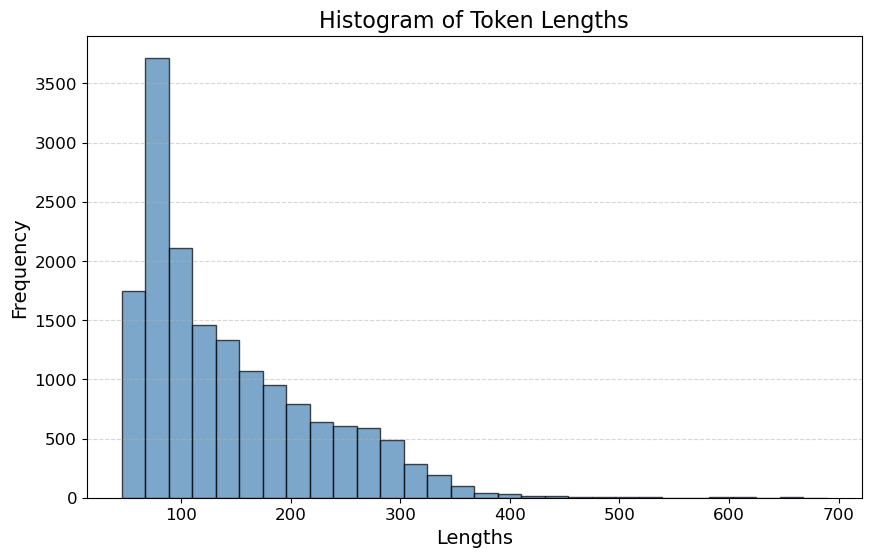

In [39]:
lengths = []
for c in pre_merged_anime['generated_description']:
    lengths.append(model.tokenizer(c, return_tensors='pt')['input_ids'].shape[1])
    
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'correlations' is a dictionary containing your data

# Set up the plot and histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black', color='steelblue', alpha=0.7)

# Customize the plot's appearance
plt.title("Histogram of Token Lengths", fontsize=16)
plt.xlabel("Lengths", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

# Display the histogram
plt.show()


In [262]:
# Combine positive and negative pairs for the validation set
all_examples_val = val_positive_pairs + val_negative_pairs

# Create a DataLoader for the validation examples
val_dataloader = DataLoader(
    all_examples_val,
    batch_size=16,
    shuffle=True
)

# Define the loss function
loss = losses.CosineSimilarityLoss(model=model)

# Extract sentences and scores from the validation examples
val_sentences1 = [ex.texts[0] for ex in all_examples_val]
val_sentences2 = [ex.texts[1] for ex in all_examples_val]
val_scores = [ex.label for ex in all_examples_val]

# Create the evaluator
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_sentences1, val_sentences2, val_scores)


In [46]:
SentenceTransformer('paraphrase-distilroberta-base-v1').evaluate(evaluator)  # original architecture cuts off so much context becasue limit is 128

2023-04-24 08:42:39 - Load pretrained SentenceTransformer: paraphrase-distilroberta-base-v1
2023-04-24 08:42:40 - Use pytorch device: cuda
2023-04-24 08:42:40 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2023-04-24 08:42:42 - Cosine-Similarity :	Pearson: -0.3144	Spearman: -0.3086
2023-04-24 08:42:42 - Manhattan-Distance:	Pearson: -0.3988	Spearman: -0.3878
2023-04-24 08:42:42 - Euclidean-Distance:	Pearson: -0.3999	Spearman: -0.3912
2023-04-24 08:42:42 - Dot-Product-Similarity:	Pearson: -0.1789	Spearman: -0.1800


-0.18002233783315705

In [47]:
model.evaluate(evaluator)

2023-04-24 08:42:42 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2023-04-24 08:42:45 - Cosine-Similarity :	Pearson: -0.2338	Spearman: -0.2173
2023-04-24 08:42:45 - Manhattan-Distance:	Pearson: -0.3344	Spearman: -0.3127
2023-04-24 08:42:45 - Euclidean-Distance:	Pearson: -0.3290	Spearman: -0.3069
2023-04-24 08:42:45 - Dot-Product-Similarity:	Pearson: -0.0850	Spearman: -0.0716


-0.07156819860087184

In [48]:
# Combine positive and negative pairs
train_examples = train_positive_pairs + train_negative_pairs

# Create a DataLoader for the examples
train_dataloader = DataLoader(
    train_examples,
    batch_size=16,
    shuffle=True
)

# Define the loss function
loss = losses.CosineSimilarityLoss(model=model)

# Train the model
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

# Configure the training
model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    output_path="anime_encoder"
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/145 [00:00<?, ?it/s]

2023-04-24 08:43:51 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 0:
2023-04-24 08:43:54 - Cosine-Similarity :	Pearson: 0.7982	Spearman: 0.7847
2023-04-24 08:43:54 - Manhattan-Distance:	Pearson: 0.6105	Spearman: 0.6440
2023-04-24 08:43:54 - Euclidean-Distance:	Pearson: 0.6301	Spearman: 0.6594
2023-04-24 08:43:54 - Dot-Product-Similarity:	Pearson: 0.7791	Spearman: 0.7686
2023-04-24 08:43:54 - Save model to anime_encoder


Iteration:   0%|          | 0/145 [00:00<?, ?it/s]

2023-04-24 08:45:03 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 1:
2023-04-24 08:45:06 - Cosine-Similarity :	Pearson: 0.9244	Spearman: 0.8531
2023-04-24 08:45:06 - Manhattan-Distance:	Pearson: 0.8117	Spearman: 0.8083
2023-04-24 08:45:06 - Euclidean-Distance:	Pearson: 0.8231	Spearman: 0.8114
2023-04-24 08:45:06 - Dot-Product-Similarity:	Pearson: 0.9214	Spearman: 0.8489
2023-04-24 08:45:06 - Save model to anime_encoder


Iteration:   0%|          | 0/145 [00:00<?, ?it/s]

2023-04-24 08:46:13 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 2:
2023-04-24 08:46:16 - Cosine-Similarity :	Pearson: 0.9442	Spearman: 0.8569
2023-04-24 08:46:16 - Manhattan-Distance:	Pearson: 0.8382	Spearman: 0.8139
2023-04-24 08:46:16 - Euclidean-Distance:	Pearson: 0.8468	Spearman: 0.8156
2023-04-24 08:46:16 - Dot-Product-Similarity:	Pearson: 0.9386	Spearman: 0.8559
2023-04-24 08:46:16 - Save model to anime_encoder


Iteration:   0%|          | 0/145 [00:00<?, ?it/s]

2023-04-24 08:47:24 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 3:
2023-04-24 08:47:27 - Cosine-Similarity :	Pearson: 0.9517	Spearman: 0.8605
2023-04-24 08:47:27 - Manhattan-Distance:	Pearson: 0.8725	Spearman: 0.8249
2023-04-24 08:47:27 - Euclidean-Distance:	Pearson: 0.8786	Spearman: 0.8250
2023-04-24 08:47:27 - Dot-Product-Similarity:	Pearson: 0.9514	Spearman: 0.8579
2023-04-24 08:47:27 - Save model to anime_encoder


Iteration:   0%|          | 0/145 [00:00<?, ?it/s]

2023-04-24 08:48:36 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 4:
2023-04-24 08:48:39 - Cosine-Similarity :	Pearson: 0.9524	Spearman: 0.8601
2023-04-24 08:48:39 - Manhattan-Distance:	Pearson: 0.8707	Spearman: 0.8197
2023-04-24 08:48:39 - Euclidean-Distance:	Pearson: 0.8764	Spearman: 0.8193
2023-04-24 08:48:39 - Dot-Product-Similarity:	Pearson: 0.9502	Spearman: 0.8580


In [49]:
model.evaluate(evaluator)

2023-04-24 08:48:39 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2023-04-24 08:48:42 - Cosine-Similarity :	Pearson: 0.9524	Spearman: 0.8601
2023-04-24 08:48:42 - Manhattan-Distance:	Pearson: 0.8707	Spearman: 0.8197
2023-04-24 08:48:42 - Euclidean-Distance:	Pearson: 0.8764	Spearman: 0.8193
2023-04-24 08:48:42 - Dot-Product-Similarity:	Pearson: 0.9502	Spearman: 0.8580


0.860054093114362

In [50]:
# Save the fine-tuned model
model.save("anime_encoder")


2023-04-24 08:48:42 - Save model to anime_encoder


In [66]:
import torch
torch.cuda.empty_cache()

In [62]:
from sentence_transformers import SentenceTransformer, evaluation, losses

# Load a pre-trained SBERT model
model = SentenceTransformer('all-mpnet-base-v2')
model

2023-04-24 09:02:34 - Load pretrained SentenceTransformer: all-mpnet-base-v2
2023-04-24 09:02:35 - Use pytorch device: cuda


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [63]:
# Combine positive and negative pairs
train_examples = train_positive_pairs + train_negative_pairs

# Create a DataLoader for the examples
train_dataloader = DataLoader(
    train_examples,
    batch_size=8,
    shuffle=True
)

# Define the loss function
loss = losses.CosineSimilarityLoss(model=model)


In [73]:
import torch

device_index = 1  # change this to the index of the GPU you want to use
torch.cuda.set_device(device_index)


In [74]:
model.evaluate(evaluator)

2023-04-24 09:08:04 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2023-04-24 09:08:15 - Cosine-Similarity :	Pearson: 0.0581	Spearman: 0.0738
2023-04-24 09:08:15 - Manhattan-Distance:	Pearson: 0.0274	Spearman: 0.0483
2023-04-24 09:08:15 - Euclidean-Distance:	Pearson: 0.0479	Spearman: 0.0738
2023-04-24 09:08:15 - Dot-Product-Similarity:	Pearson: 0.0581	Spearman: 0.0738


0.07383366675802173

In [75]:

# Train the model
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

# Configure the training
model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    evaluator=evaluator,
    output_path="anime_encoder_bigger"
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/289 [00:00<?, ?it/s]

2023-04-24 09:11:43 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 0:
2023-04-24 09:11:53 - Cosine-Similarity :	Pearson: 0.5348	Spearman: 0.5376
2023-04-24 09:11:53 - Manhattan-Distance:	Pearson: 0.5117	Spearman: 0.5292
2023-04-24 09:11:53 - Euclidean-Distance:	Pearson: 0.5194	Spearman: 0.5376
2023-04-24 09:11:53 - Dot-Product-Similarity:	Pearson: 0.5348	Spearman: 0.5376
2023-04-24 09:11:53 - Save model to anime_encoder_bigger


Iteration:   0%|          | 0/289 [00:00<?, ?it/s]

2023-04-24 09:15:22 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 1:
2023-04-24 09:15:32 - Cosine-Similarity :	Pearson: 0.6965	Spearman: 0.6860
2023-04-24 09:15:32 - Manhattan-Distance:	Pearson: 0.6738	Spearman: 0.6825
2023-04-24 09:15:32 - Euclidean-Distance:	Pearson: 0.6766	Spearman: 0.6860
2023-04-24 09:15:32 - Dot-Product-Similarity:	Pearson: 0.6965	Spearman: 0.6860
2023-04-24 09:15:32 - Save model to anime_encoder_bigger


Iteration:   0%|          | 0/289 [00:00<?, ?it/s]

2023-04-24 09:19:01 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 2:
2023-04-24 09:19:11 - Cosine-Similarity :	Pearson: 0.7802	Spearman: 0.7341
2023-04-24 09:19:11 - Manhattan-Distance:	Pearson: 0.7705	Spearman: 0.7296
2023-04-24 09:19:11 - Euclidean-Distance:	Pearson: 0.7725	Spearman: 0.7341
2023-04-24 09:19:11 - Dot-Product-Similarity:	Pearson: 0.7802	Spearman: 0.7341
2023-04-24 09:19:11 - Save model to anime_encoder_bigger


Iteration:   0%|          | 0/289 [00:00<?, ?it/s]

2023-04-24 09:22:38 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 3:
2023-04-24 09:22:47 - Cosine-Similarity :	Pearson: 0.8430	Spearman: 0.7949
2023-04-24 09:22:47 - Manhattan-Distance:	Pearson: 0.8344	Spearman: 0.7910
2023-04-24 09:22:47 - Euclidean-Distance:	Pearson: 0.8364	Spearman: 0.7949
2023-04-24 09:22:47 - Dot-Product-Similarity:	Pearson: 0.8430	Spearman: 0.7949
2023-04-24 09:22:47 - Save model to anime_encoder_bigger


Iteration:   0%|          | 0/289 [00:00<?, ?it/s]

2023-04-24 09:26:13 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset after epoch 4:
2023-04-24 09:26:23 - Cosine-Similarity :	Pearson: 0.8896	Spearman: 0.8260
2023-04-24 09:26:23 - Manhattan-Distance:	Pearson: 0.8781	Spearman: 0.8220
2023-04-24 09:26:23 - Euclidean-Distance:	Pearson: 0.8808	Spearman: 0.8260
2023-04-24 09:26:23 - Dot-Product-Similarity:	Pearson: 0.8896	Spearman: 0.8260
2023-04-24 09:26:23 - Save model to anime_encoder_bigger


In [76]:
model.save('anime_encoder_bigger')

2023-04-24 09:26:24 - Save model to anime_encoder_bigger


In [1]:
import openai, os
from openai.embeddings_utils import get_embeddings, get_embedding

openai.api_key = os.environ.get('OPENAI_API_KEY')


In [267]:
# del embeddings['anime_encoder']
embeddings = {}

In [268]:
embedders = ('text-embedding-ada-002', 'paraphrase-distilroberta-base-v1', 'anime_encoder', 'anime_encoder_bigger')


In [269]:
from tqdm.auto import tqdm

'''
Given a user id

for each anime that the user gave a 9 or a 10 for:
    get k other relevant animes (semantic search given an embedder)
    for each relevant anime:
        if the anime was rating in the training set for that user, ignore
        elif the anime is not present in the testing set for that user, ignore
        else:
            check rating in testing for that user
            case rating:
                9,10 -> Promoter  ( + 2 points)
                7,8  -> Passive   ( + 1 point )
                1-6  -> Detractor ( - 1 point )
                Not in the set    (   0 points)

'''

from sentence_transformers import SentenceTransformer

docs = pre_merged_anime['generated_description'].tolist()
for embedder in embedders:
    if embedder in embeddings:
        continue
    if 'ada' in embedder:
        ada_embeddings = None
        for s in tqdm(range(0, len(docs), 100)):
            if ada_embeddings is None:
                ada_embeddings = np.array(get_embeddings(docs[s:s+100], engine=embedder))
            else:
                ada_embeddings = np.vstack([ada_embeddings, np.array(get_embeddings(docs[s:s+100], engine=embedder))])
    
        embeddings[embedder] = ada_embeddings
    else:
        e = SentenceTransformer(embedder)
        embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)


  0%|          | 0/163 [00:00<?, ?it/s]

2023-04-25 08:31:36 - Load pretrained SentenceTransformer: paraphrase-distilroberta-base-v1
2023-04-25 08:31:38 - Use pytorch device: cuda


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

2023-04-25 08:32:05 - Load pretrained SentenceTransformer: anime_encoder
2023-04-25 08:32:06 - Use pytorch device: cuda


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

2023-04-25 08:32:50 - Load pretrained SentenceTransformer: anime_encoder_bigger
2023-04-25 08:32:51 - Use pytorch device: cuda


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

2023-04-25 08:34:18 - Load pretrained SentenceTransformer: anime_encoder_even_bigger
2023-04-25 08:34:21 - Use pytorch device: cuda


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

In [270]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrices = {embedder: cosine_similarity(embeddings[embedder]) for embedder in embedders}


In [271]:
import functools
from typing import List, Tuple

@functools.lru_cache(maxsize=None)
def get_similar_animes(anime_id: int, embedder: str, k: int = 10, verbose: bool = False) -> List[Tuple[int, float]]:
    # Get the index of the anime in the pre_merged_anime dataframe
    try:
        idx = pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id].index[0]
    except:
        return []
    if verbose:
        print(f'idx: {idx}')
    cosine_sim_matrix = cosine_sim_matrices[embedder]

    # Get the cosine similarity scores for the given anime_id
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the animes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices and scores of the k most similar animes
    k_indices_scores = sim_scores[1:k+1]

    # Separate indices and scores
    k_indices = [i[0] for i in k_indices_scores]
    k_scores = [round(i[1], 3) for i in k_indices_scores]

    # Get the MAL_IDs of the k most similar animes
    k_anime_ids = pre_merged_anime['MAL_ID'].iloc[k_indices].tolist()

    # Return the MAL_IDs and their corresponding similarity scores
    return list(zip(k_anime_ids, k_scores))


In [54]:
pre_merged_anime[pre_merged_anime['MAL_ID'].isin((1723, 4059))]

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis,generated_description
1497,1723,Clannad Movie,7.25,"Drama, Romance, Fantasy, School",Clannad The Motion Picture,Movie,1,Unknown,Unknown,Toei Animation,Visual novel,1 hr. 33 min.,PG-13 - Teens 13 or older,2566.0,143560,458,104445,1474,Tomoya Okazaki is a cynical delinquent who lac...,Clannad Movie is a Movie.\nSynopsis: Tomoya Ok...
3057,4059,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen",8.0,"Drama, Romance, School, Slice of Life","Clannad:Another World, Tomoyo Chapter",Special,1,Unknown,Pony Canyon,Kyoto Animation,Visual novel,25 min.,PG-13 - Teens 13 or older,534.0,255959,873,230911,875,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is s...","Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is a..."


In [7]:
anime_id = 4059
k = 10
for e in embedders:
    similar_animes = get_similar_animes(anime_id, e, k=3, verbose=True)
    print(e)
    print(similar_animes)
    print()


idx: 3057
text-embedding-ada-002
[(6351, 0.921), (1723, 0.908), (2167, 0.905)]

idx: 3057
paraphrase-distilroberta-base-v1
[(17835, 0.594), (33970, 0.589), (1723, 0.586)]

idx: 3057
anime_encoder
[(2167, 0.989), (907, 0.988), (18599, 0.987)]

idx: 3057
anime_encoder_bigger
[(39741, 0.99), (323, 0.989), (34299, 0.987)]


In [273]:
def get_promoted_animes_from_user(user_id):
    return rating_complete_train[(rating_complete_train['user_id'] == user_id) & (rating_complete_train['rating'] >= 9)]['anime_id'].tolist()
    

In [275]:
def get_relevant_animes(reference_promoted_anime_id, embedder, k=5, verbose=True):
    preds = []
    similar_animes = get_similar_animes(reference_promoted_anime_id, embedder, k=k)

    for similar_anime_id, cosine_score in similar_animes:
        if cosine_score >= 1:
            continue  # ignoring exact matches
        if verbose:
            print(f'Recommending (ID {similar_anime_id}) Cos_Sim {cosine_score:.3f}')
            print(f'User gave it a rating of: {user_rating}')
        preds.append((similar_anime_id, cosine_score))
    return preds
                     

In [276]:
user_preds = {}

In [277]:
from collections import defaultdict
import concurrent.futures
from functools import partial
from tqdm import tqdm

def process_user(user_id, embedders, K, verbose=False):
    user_predictions = {e: defaultdict(float) for e in embedders}
    for promoted_anime_id in set(get_promoted_animes_from_user(user_id)):
        for embedder in embedders:
            relevant_animes = get_relevant_animes(promoted_anime_id, embedder, verbose=False, k=K)
            for anime_id, cosine_score in relevant_animes:
                if verbose:
                    print(embedder, user_id, promoted_anime_id, anime_id, cosine_score)
                if anime_id not in user_predictions[embedder] or cosine_score > user_predictions[embedder][anime_id]:
                    user_predictions[embedder][anime_id] = cosine_score
    return user_id, user_predictions

# Prepare the data
user_ids = rating_complete_test['user_id'].unique()[len(user_preds):]

# Set the number of workers and the value for K
num_workers = min(8, len(user_ids))
K = 3


In [279]:
# Parallelize the code using multiple threads
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Create a partial function with fixed arguments for embedders and K
    process_user_partial = partial(process_user, embedders=embedders, K=K)
    
    # Run the tasks in parallel and update the user_preds dictionary
    for user_id, user_predictions in tqdm(executor.map(process_user_partial, user_ids), total=len(user_ids)):
        user_preds[user_id] = user_predictions


In [145]:
len(user_preds)

285789

In [146]:
process_user(205282, embedders, K=3)

(205282,
 {'text-embedding-ada-002': defaultdict(float,
              {5: 0.914,
               17205: 0.882,
               4037: 0.878,
               21507: 0.911,
               33775: 0.874,
               21195: 0.873,
               1: 0.914,
               20359: 0.955,
               24627: 0.951,
               1562: 0.898,
               23277: 0.96,
               36885: 0.942,
               29317: 0.937,
               4106: 0.927,
               28791: 0.853,
               1200: 0.848,
               22729: 0.927,
               33051: 0.878,
               29223: 0.887,
               39587: 0.944,
               42203: 0.947,
               38414: 0.915,
               39940: 0.938,
               32282: 0.937,
               35788: 0.93,
               11597: 0.943,
               28025: 0.929,
               5081: 0.943,
               31758: 0.942,
               9260: 0.927,
               31757: 0.942,
               19291: 0.926,
               40351: 0.925,
   

In [147]:
import json

# Convert int64 keys to int or str
import json

def convert_float32(obj):
    if isinstance(obj, dict):
        return {key: convert_float32(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_float32(item) for item in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

user_preds_converted = {int(key): value for key, value in user_preds.items()}
user_preds_converted = convert_float32(user_preds_converted)

# save this because it was computationally expensive to create
with open('user_preds.json', 'w') as f:
    json.dump(user_preds_converted, f)


In [8]:
import json
with open('user_preds.json', 'rU') as f:
    user_preds = json.load(f)

In [149]:
total_animes_predicted = {e: set() for e in embedders}
for user_id, recs in user_preds.items():
    for embedder, rec in recs.items():
        total_animes_predicted[embedder].update((rec.keys()))
len(total_animes_predicted)

4

In [280]:
rating_complete_test['anime_id'].nunique()

In [281]:
{k: len(v) for k, v in total_animes_predicted.items()}


In [152]:
rating_complete_test

,user_id,anime_id,rating
57039029,349749,154,9
33418394,205282,18001,9
18511337,113697,10110,9
53862736,330116,37520,7
30501411,187612,209,10
...,...,...,...
13315092,81644,5178,3
21081788,129703,10721,9
56882282,348777,11499,8
49648910,304381,10702,7


In [153]:
from collections import defaultdict
try:
    user_anime_test_ratings
except:
    user_anime_test_ratings = defaultdict(dict)
    for index, user_id, anime_id, rating in tqdm(rating_complete_test.to_records()):
        user_anime_test_ratings[user_id][anime_id] = rating


In [ ]:
# Importing tqdm for progress bar visualization
from tqdm.auto import tqdm

# Creating a map to score user ratings.
# 10 and 9 are considered positive (1), 8 and 7 are neutral (0), and all others are considered negative (-1)
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}

# Initializing list for k_values and dictionary for counts of each embedder
k_values = []
embedder_counts = defaultdict(list)

# Creating a range of integers from 1 to 10
_r = list(range(1, 11))

# Looping over the range to get the different k values (k-factor) for recommendations
for k_factor in tqdm(_r):
    # Looping over each user and their corresponding recommendations
    for user_id, user_recs in user_preds.items():
        # Looping over each embedder and the corresponding recommendations from the embedder
        for embedder, recs_from_embedder in user_recs.items():
            # Selecting the top-k recommendations for each user from each embedder
            final_recs = sorted(recs_from_embedder.items(), key=lambda x: x[1], reverse=True)[:k_factor]

            # Looping over the top-k recommendations
            for index, (recommended_anime_id, recommendation_score) in enumerate(final_recs):  
                # Fetching the user rating for the recommended anime
                user_rating = user_anime_test_ratings.get(int(user_id), {}).get(int(recommended_anime_id))

                # Checking if the user has a rating for the recommended anime
                if user_rating:
                    # The score of each recommendation is adjusted by its rank and added to the embedder_counts dictionary
                    embedder_counts[embedder].append((score_map[user_rating] * (k_factor - index) / k_factor))

    # Calculating the average Net Promoter Score (NPS) for each embedder and adding it to the k_values list
    k_values.append({e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()})


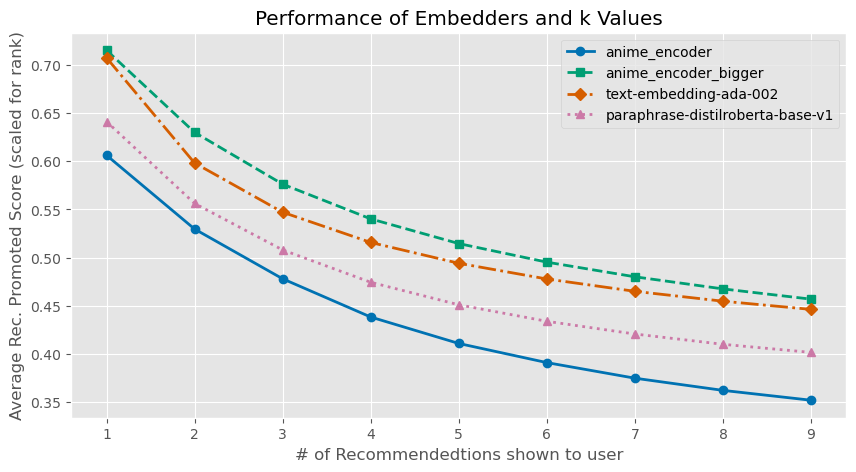

In [228]:
import matplotlib.pyplot as plt

# Extract the data
models = list(k_values[0].keys())
ks = [entry[models[0]]["k"] for entry in k_values]
model_avg_nps = {model: [entry[model]["avg_nps"] for entry in k_values] for model in models}

# Create a single figure with modern styling
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Define color-blind friendly colors, line styles, and marker styles
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
line_styles = ['-', '--', '-.', ':']
marker_styles = ['o', 's', 'D', '^']

# Plot lines for each model
for idx, (model, avg_nps) in enumerate(model_avg_nps.items()):
    ax.plot(ks, avg_nps, label=model, linewidth=2, marker=marker_styles[idx], linestyle=line_styles[idx], color=colors[idx])

# Add labels, title, and legend
ax.set_xlabel('# of Recommendedtions shown to user')
ax.set_ylabel('Average Rec. Promoted Score (scaled for rank)')
ax.set_title('Performance of Embedders and k Values')
ax.legend()

# Display the graph
plt.show()


In [239]:
df = pd.DataFrame(graph_scores_by_k).T

df

,anime_encoder_avg,anime_encoder_bigger_avg,text-embedding-ada-002_avg,paraphrase-distilroberta-base-v1_avg
1,0.606310,0.715316,0.707477,0.641283
2,0.450873,0.617474,0.735131,0.609570
3,0.466259,0.590638,0.711768,0.615678
4,0.474589,0.559918,0.703781,0.616045
5,0.470490,0.519009,0.687056,0.616407
6,0.452965,0.500867,0.670499,0.610668
7,0.471801,0.463763,0.660379,0.602164
8,0.441482,0.434208,0.668584,0.606114
9,0.428241,0.429510,0.647485,0.600284
10,0.446724,0.406008,0.649871,0.602507
